<a href="https://colab.research.google.com/github/nyk-nyk/notes-about-handson-ml/blob/master/HOM_Chapter16_Natural_Language_Processing_with_RNNs_and_Attention_Code_Snippet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    !pip install -q -U transformers
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

     |████████████████████████████████| 706kB 18.8MB/s 
     |████████████████████████████████| 2.2MB 17.4MB/s 
     |████████████████████████████████| 3.3MB 52.1MB/s 
     |████████████████████████████████| 870kB 47.1MB/s 


In [2]:
rng = np.random.default_rng(seed=42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)

In [3]:
for index, (X_batch, Y_batch) in enumerate(dataset):
  print("_" * 20, "Batch", index, "\nX_batch")
  print(X_batch.numpy())
  print("=" * 5, "\nY_batch")
  print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


In [4]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1122304/1115394 [==============================] - 0s 0us/step


In [5]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [6]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [7]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [8]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [9]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [10]:
max_id = len(tokenizer.word_index) # number of distinct characters

In [11]:
dataset_size = tokenizer.document_count # total number of characters

In [12]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 1000
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [13]:
dataset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=100385>

In [14]:
dataset.repeat().cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=-1>

In [15]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

In [16]:
dataset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=-1>

In [17]:
for each in dataset.take(3):
  print(list(each.as_numpy_iterator()))

[19, 5, 8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9, 23, 10, 21, 1, 19, 3, 8, 1, 0, 16, 1, 0, 22, 8, 3, 18, 1, 1, 12, 0, 4, 9, 15, 0, 19, 13, 8, 2, 6, 1, 8, 17, 0, 6, 1, 4, 8, 0, 14, 1, 0, 7, 22, 1, 4, 24, 26, 10, 10, 4, 11, 11, 23, 10, 7, 22, 1, 4, 24, 17, 0, 7, 22, 1, 4, 24, 26, 10, 10, 19, 5, 8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9, 23, 10, 15, 3, 13, 0]
[5, 8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9, 23, 10, 21, 1, 19, 3, 8, 1, 0, 16, 1, 0, 22, 8, 3, 18, 1, 1, 12, 0, 4, 9, 15, 0, 19, 13, 8, 2, 6, 1, 8, 17, 0, 6, 1, 4, 8, 0, 14, 1, 0, 7, 22, 1, 4, 24, 26, 10, 10, 4, 11, 11, 23, 10, 7, 22, 1, 4, 24, 17, 0, 7, 22, 1, 4, 24, 26, 10, 10, 19, 5, 8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9, 23, 10, 15, 3, 13, 0, 4]
[8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9, 23, 10, 21, 1, 19, 3, 8, 1, 0, 16, 1, 0, 22, 8, 3, 18, 1, 1, 12, 0, 4, 9, 15, 0, 19, 13, 8, 2, 6, 1, 8, 17, 0, 6, 1, 4, 8, 0, 14, 1, 0, 7, 22, 1, 4, 24, 26, 10, 10, 4, 11, 11, 23, 10, 7, 22, 1, 4, 24, 17, 0, 7, 22, 1, 4, 24, 26, 10, 10, 19, 5, 8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9

In [18]:
for each in dataset.take(3):
  print(type(each.batch(window_length)))
  print(list(each.batch(window_length).as_numpy_iterator()))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
[array([19,  5,  8,  7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 21,  1,
       19,  3,  8,  1,  0, 16,  1,  0, 22,  8,  3, 18,  1,  1, 12,  0,  4,
        9, 15,  0, 19, 13,  8,  2,  6,  1,  8, 17,  0,  6,  1,  4,  8,  0,
       14,  1,  0,  7, 22,  1,  4, 24, 26, 10, 10,  4, 11, 11, 23, 10,  7,
       22,  1,  4, 24, 17,  0,  7, 22,  1,  4, 24, 26, 10, 10, 19,  5,  8,
        7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 15,  3, 13,  0])]
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
[array([ 5,  8,  7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 21,  1, 19,
        3,  8,  1,  0, 16,  1,  0, 22,  8,  3, 18,  1,  1, 12,  0,  4,  9,
       15,  0, 19, 13,  8,  2,  6,  1,  8, 17,  0,  6,  1,  4,  8,  0, 14,
        1,  0,  7, 22,  1,  4, 24, 26, 10, 10,  4, 11, 11, 23, 10,  7, 22,
        1,  4, 24, 17,  0,  7, 22,  1,  4, 24, 26, 10, 10, 19,  5,  8,  7,
        2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 

In [19]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [20]:
rng = np.random.default_rng(seed=42)
tf.random.set_seed(42)

In [21]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)


In [22]:
for each in dataset.take(3):
  print(each)

tf.Tensor(
[[ 6  5  7 ...  0 18  4]
 [ 6  1  0 ...  0 11  1]
 [11 12  0 ... 29 10 10]
 ...
 [ 3 27  0 ...  7  3 19]
 [18  3  9 ...  4  9  7]
 [14  7  0 ...  8  1  0]], shape=(32, 101), dtype=int64)
tf.Tensor(
[[ 3  8 24 ...  5  8  7]
 [ 7 30 10 ...  8  0  3]
 [26  0  6 ...  6  4  2]
 ...
 [ 7  0 21 ... 15 17 10]
 [ 7  5 12 ... 13  1  7]
 [10 19  5 ...  2  3  0]], shape=(32, 101), dtype=int64)
tf.Tensor(
[[ 3 11 25 ... 10 16  1]
 [ 1 14  1 ...  1  9  2]
 [15  3 13 ...  0  2  3]
 ...
 [14 15  0 ...  0 16  1]
 [ 2  0  9 ...  6  3 13]
 [12  0 19 ...  5  8  1]], shape=(32, 101), dtype=int64)


In [23]:
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [24]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [25]:
dataset = dataset.prefetch(1)

In [26]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


In [27]:
dataset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=-2>

In [28]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2,
                     dropout=0.2, batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True, dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))                     
])

In [29]:
class ResetStatesCallBack(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

In [30]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps
history = model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=50, callbacks=[ResetStatesCallBack()])

Epoch 1/50
31/31 [==============================] - 34s 16ms/step - loss: 3.4470
Epoch 2/50
31/31 [==============================] - 0s 12ms/step - loss: 3.0047
Epoch 3/50
31/31 [==============================] - 0s 12ms/step - loss: 2.8153
Epoch 4/50
31/31 [==============================] - 0s 12ms/step - loss: 2.5695
Epoch 5/50
31/31 [==============================] - 0s 12ms/step - loss: 2.4593
Epoch 6/50
31/31 [==============================] - 0s 12ms/step - loss: 2.4064
Epoch 7/50
31/31 [==============================] - 0s 12ms/step - loss: 2.3581
Epoch 8/50
31/31 [==============================] - 0s 12ms/step - loss: 2.3489
Epoch 9/50
31/31 [==============================] - 0s 12ms/step - loss: 2.3175
Epoch 10/50
31/31 [==============================] - 0s 12ms/step - loss: 2.2942
Epoch 11/50
31/31 [==============================] - 0s 12ms/step - loss: 2.2165
Epoch 12/50
31/31 [==============================] - 0s 12ms/step - loss: 2.1865
Epoch 13/50
31/31 [=================

In [31]:
def preprocess(texts):
  X = np.array(tokenizer.texts_to_sequences(texts)) - 1
  return tf.one_hot(X, max_id)

In [32]:
X_new = preprocess(["How are yo"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'u'

In [33]:
def next_char(text, temperature=1):
  X_new = preprocess([text])
  y_proba = model.predict(X_new)[0, -1:, :]
  rescaled_logits = tf.math.log(y_proba) / temperature
  char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
  return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [34]:
def complete_text(text, n_chars=50, temperature=1):
  for _ in range(n_chars):
    text += next_char(text, temperature)
  return text

In [35]:
#print(complete_text("t", temperature=0.2))
#print(complete_text("t", temperature=1))
#print(complete_text("t", temperature=2))

In [36]:
tf.random.set_seed(42)

In [37]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.repeat().batch(1)
dataset = dataset.map(lambda windows:(windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [38]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [39]:
model = keras.models.Sequential(
    [
     keras.layers.GRU(128, return_sequences=True, stateful=True, dropout=0.2, batch_input_shape=[batch_size, None, max_id]),
     keras.layers.GRU(128, return_sequences=True, stateful=True, dropout=0.2),
     keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))
    ]
)

In [40]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [41]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps
history = model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=50,
                    callbacks=[ResetStatesCallback()])

Epoch 1/50
31/31 [==============================] - 2s 15ms/step - loss: 3.4548
Epoch 2/50
31/31 [==============================] - 0s 13ms/step - loss: 3.0064
Epoch 3/50
31/31 [==============================] - 0s 12ms/step - loss: 2.7964
Epoch 4/50
31/31 [==============================] - 0s 13ms/step - loss: 2.5913
Epoch 5/50
31/31 [==============================] - 0s 13ms/step - loss: 2.4950
Epoch 6/50
31/31 [==============================] - 0s 12ms/step - loss: 2.4284
Epoch 7/50
31/31 [==============================] - 0s 12ms/step - loss: 2.3787
Epoch 8/50
31/31 [==============================] - 0s 12ms/step - loss: 2.3405
Epoch 9/50
31/31 [==============================] - 0s 12ms/step - loss: 2.2983
Epoch 10/50
31/31 [==============================] - 0s 12ms/step - loss: 2.2698
Epoch 11/50
31/31 [==============================] - 0s 12ms/step - loss: 2.2319
Epoch 12/50
31/31 [==============================] - 0s 12ms/step - loss: 2.1986
Epoch 13/50
31/31 [==================

In [42]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [43]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [44]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [45]:
tf.random.set_seed(42)

print(complete_text("t"))

thing addidn honour this voise, his pation aod to m


Sentiment Analysis

In [46]:
tf.random.set_seed(42)

In [47]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()
X_train[0][:10]

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [48]:
X_train.shape

(25000,)

In [49]:
type(X_train).__name__

'ndarray'

In [50]:
type(X_train[0])

list

Visualize integer ids to words

In [51]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
  id_to_word[id_] = token
" ".join([ id_to_word[id_] for id_ in X_train[0][:10]])

1646592/1641221 [==============================] - 0s 0us/step


'<sos> this film was just brilliant casting location scenery story'

Or load the IMDb reveiws as TensorFlow Datasets 

In [52]:
import tensorflow_datasets  as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteX6QYUF/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteX6QYUF/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteX6QYUF/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [53]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [54]:
list(datasets["train"].take(1).as_numpy_iterator())

[(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
  0)]

In [55]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [56]:
train_size, test_size

(25000, 25000)

In [57]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative



In [58]:
y_batch

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>

Preprocessing

In [59]:
tf.strings.substr(X_batch, 0, 300)

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda pi",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Cons'],
      dtype=object)>

In [60]:
 tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [61]:
tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b"This was an absolutely terrible movie  Don't be lured in by Christopher Walken or Michael Ironside  Both are great actors  but this must simply be their worst role in history  Even their great acting could not redeem this movie's ridiculous storyline  This movie is an early nineties US propaganda piece  The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions  Maria Conchita Alonso appeared phony  and her pseudo love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning  I am disappointed that there are movies like this  ruining actor's like Christopher Walken's good name  I could barely sit through it ",
       b'I have been known to fall asleep during films  but this is usually due to a combination of things including  really tired  being warm and comfortable on the sette and having just eaten a lot  However on this occasion I fell a

In [62]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [63]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

Counter returns key and its occurence

In [64]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [65]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [66]:
len(vocabulary)

53893

In [67]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [68]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


In [69]:
words = tf.constant(truncated_vocabulary)
words

<tf.Tensor: shape=(10000,), dtype=string, numpy=
array([b'<pad>', b'the', b'a', ..., b'PEOPLE', b'elevator', b'belie'],
      dtype=object)>

Replace each word with its iD

In [70]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [71]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

In [72]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [73]:
for X_batch, y_batch in train_set.take(1):
  print(X_batch)
  print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


In [74]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    #keras.layers.GRU(128, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    #keras.layers.GRU(128),
    keras.layers.LSTM(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 31s 32ms/step - loss: 0.5731 - accuracy: 0.6892
Epoch 2/5
781/781 [==============================] - 25s 32ms/step - loss: 0.3676 - accuracy: 0.8387
Epoch 3/5
781/781 [==============================] - 25s 32ms/step - loss: 0.2270 - accuracy: 0.9127
Epoch 4/5
781/781 [==============================] - 25s 32ms/step - loss: 0.1648 - accuracy: 0.9390
Epoch 5/5
781/781 [==============================] - 25s 32ms/step - loss: 0.1382 - accuracy: 0.9501


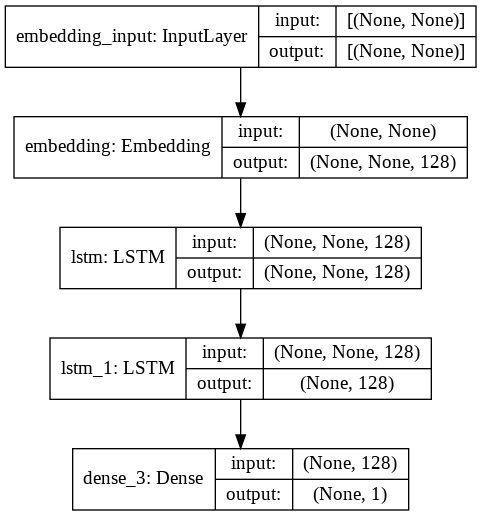

In [75]:
keras.utils.plot_model(model, "my_sentimental_analysis_model.png", show_shapes=True)

In [76]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 31s 32ms/step - loss: 0.6094 - accuracy: 0.6406
Epoch 2/5
781/781 [==============================] - 25s 32ms/step - loss: 0.3715 - accuracy: 0.8425
Epoch 3/5
781/781 [==============================] - 25s 32ms/step - loss: 0.1961 - accuracy: 0.9270
Epoch 4/5
781/781 [==============================] - 25s 32ms/step - loss: 0.1267 - accuracy: 0.9548
Epoch 5/5
781/781 [==============================] - 25s 32ms/step - loss: 0.1052 - accuracy: 0.9606


In [77]:
tf.random.set_seed(42)

In [78]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [79]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [80]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
  for filename in filenames:
    print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001


In [81]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Epoch 1/5
781/781 [==============================] - 5s 6ms/step - loss: 0.5861 - accuracy: 0.6919
Epoch 2/5
781/781 [==============================] - 4s 5ms/step - loss: 0.5181 - accuracy: 0.7445
Epoch 3/5
781/781 [==============================] - 4s 6ms/step - loss: 0.5122 - accuracy: 0.7491
Epoch 4/5
781/781 [==============================] - 4s 5ms/step - loss: 0.5084 - accuracy: 0.7492
Epoch 5/5
781/781 [==============================] - 4s 6ms/step - loss: 0.5054 - accuracy: 0.7520


Automatic Translation

In [82]:
tf.random.set_seed(42)

In [83]:
vocab_size = 100
embed_size = 100

In [84]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

In [85]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [86]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
32/32 [==============================] - 4s 48ms/step - loss: 4.6053
Epoch 2/2
32/32 [==============================] - 1s 47ms/step - loss: 4.5989


In [87]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    10000       input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 512), (None, 1255424     embedding_2[0][0]          

In [88]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________
